# Grazing model for Chagos Rats

The models here will be run in [Python](https://www.python.org), using the [PyMC3 package](https://github.com/pymc-devs/pymc3).

### Data wrangling

The first step is to instantiate the various python packages needed for the analysis:

In [1]:
# Import packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.basemap import Basemap as bm
from scipy.stats import gaussian_kde
import scipy as sp
import pymc3 as pm
import theano.tensor as tt
import matplotlib as mp
import sqlite3
import os


# Return list of unique items and an index of their position in L
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

# Return list of unique items and an index of their position in long, relative to short
def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(2*np.std(x))

# Path to plot storage
plotdir = os.getcwd()+'/plots'

/Users/aaronmacneil/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Import age and growth data
xdata = pd.read_excel('Rats_birds_func.xlsx')
xdata.head()

,Treatment,Atoll,Island,Transect,grazing_prop_reef,Erosion_t_ha,Structural_complexity,Coral_cover
0,No_rats,Great_Chagos_Bank,Middle_Brother,1,11.800741,155.013787,3.000000,6.330
1,No_rats,Great_Chagos_Bank,Middle_Brother,2,11.303339,121.614844,2.987179,40.330
2,No_rats,Great_Chagos_Bank,Middle_Brother,3,3.511624,62.013236,2.000000,23.692
3,No_rats,Great_Chagos_Bank,Middle_Brother,4,2.211482,34.852228,2.000000,32.000
4,No_rats,Great_Chagos_Bank,Nelson_Island,1,18.567027,154.658501,1.500000,12.670


In [3]:
# Response
grazing = np.round(xdata.grazing_prop_reef.values)
#grazing[grazing>100] = 100
erosion = xdata.Erosion_t_ha.values

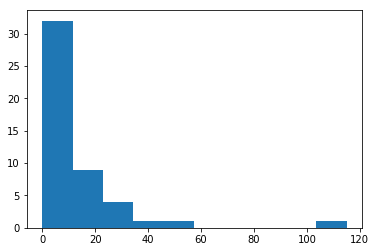

In [4]:
plt.hist(grazing);

In [5]:
# Covariates
complexity = xdata.Structural_complexity.values
hc = xdata.Coral_cover.values
rats = 1*(xdata.Treatment.values!='No_rats')

# Hierarchy
Island,Is = indexall(xdata.Island.values)
nisland = len(Island)

# Total biomass model

In [6]:
Model = pm.Model()

with Model:
    
    # Global prior
    γ = pm.Normal('Average_grazing', mu=0.0, tau=0.001)
    # Inter-island variablity
    σγ = pm.Uniform('SD_reef', lower=0, upper=100)
    τγ = σγ**-2
    β0 = pm.Normal('Island_d15N', mu=γ, tau=τγ, shape=nisland)
    
    # Rat effect
    β1 = pm.Normal('Rat_effect', mu=0.0, tau=0.001)
    # Structural complexity
    β2 = pm.Normal('complexity', mu=0.0, tau=0.001)
    # Hard coral
    β3 = pm.Normal('hc', mu=0.0, tau=0.001)
    
    # Mean model
    μ = β0[Is]+β1*rats+β2*complexity+β3*hc

    λ = tt.exp(μ)

    # Likelihood
    Yi = pm.Poisson('Yi', λ, observed=grazing)

In [7]:
# Sampling
with Model:
    #db = pm.backends.Text('Rats_chagos_results')
    trace = pm.sample(5000, njobs=2, progressbar=True, init=None)

Assigned NUTS to Average_grazing
Assigned NUTS to SD_reef_interval__
Assigned NUTS to Island_d15N
Assigned NUTS to Rat_effect
Assigned NUTS to complexity
Assigned NUTS to hc
/Users/aaronmacneil/anaconda/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████| 5500/5500 [00:30<00:00, 180.99it/s]


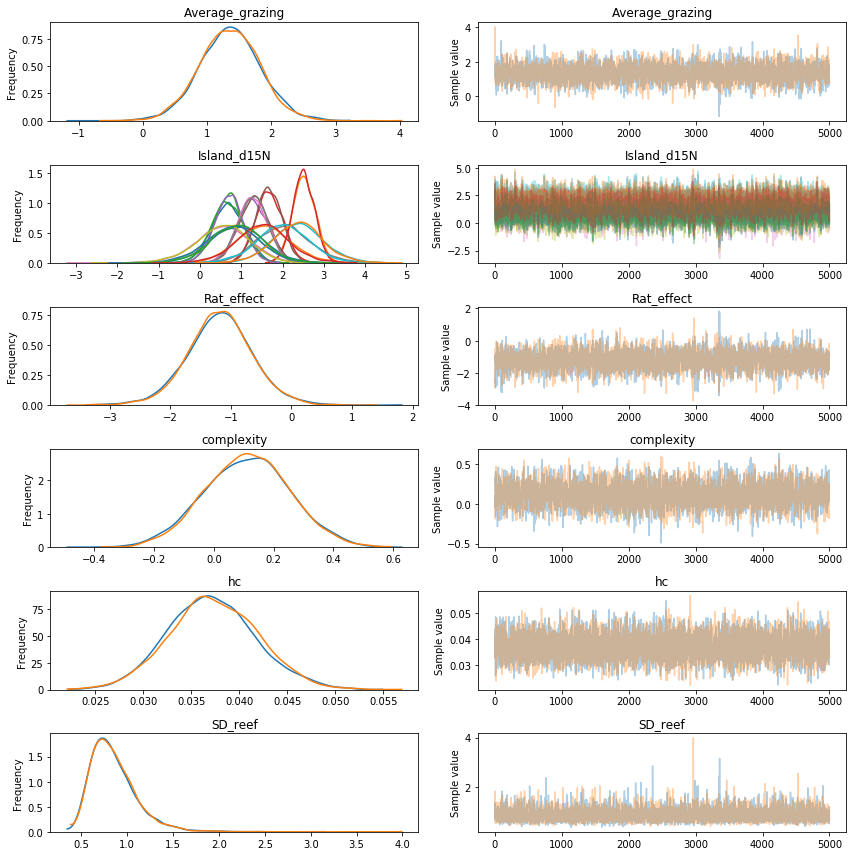

In [8]:
pm.traceplot(trace);

In [9]:
out = pm.backends.tracetab.trace_to_dataframe(trace)

In [10]:
out.head()

,Average_grazing,Island_d15N__0,Island_d15N__1,Island_d15N__2,Island_d15N__3,Island_d15N__4,Island_d15N__5,Island_d15N__6,Island_d15N__7,Island_d15N__8,Island_d15N__9,Island_d15N__10,Island_d15N__11,Rat_effect,complexity,hc,SD_reef
0,1.803362,0.328748,2.646563,0.927987,1.651360,1.439645,1.365436,0.298063,2.414163,1.494240,2.607009,1.366841,1.634559,-1.248460,0.045366,0.037599,0.749421
1,1.300587,1.301495,2.631089,0.729529,1.748330,1.333823,1.720123,1.255520,2.340648,0.450651,2.719378,1.229609,1.500904,-1.225629,0.102452,0.032757,0.825821
2,1.442308,1.139732,2.779110,1.275270,1.978738,1.527073,1.703567,-0.209314,2.100064,0.275090,2.417456,0.908210,1.661376,-0.916720,-0.050736,0.037635,0.677685
3,1.289769,0.830934,2.628790,0.686769,1.842820,1.566277,1.338605,0.313362,2.057542,1.333207,2.384549,0.743411,1.441814,-1.147019,0.013081,0.040221,0.914846
4,1.735589,0.672512,2.413854,0.822435,1.712770,1.271050,0.955241,1.106604,2.754194,0.524263,2.994151,1.355939,1.633746,-1.576963,0.082024,0.042172,1.327077


In [11]:
out.to_csv('grazing_results.csv')